In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
print(os.getcwd())
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from plotly import graph_objects as go
from scipy.stats import norm

c:\Users\osval\sprint_14_Proy_Final


Descripción técnica
<br>Nombre de la prueba: recommender_system_test
<br>Grupos: А (control), B (nuevo embudo de pago)
<br>Fecha de lanzamiento: 2020-12-07
<br>Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
<br>Fecha de finalización: 2021-01-01
<br>Audiencia: 15% de los nuevos usuarios de la región de la UE
<br>Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
<br>Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
<br>Número previsto de participantes de la prueba: 6 000

ab_project_marketing_events_us.csv — el calendario de eventos de marketing para 2020<br>
<br>final_ab_new_users_upd_us.csv — todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020<br>
<br>final_ab_events_upd_us.csv — todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021<br>
<br>final_ab_participants_upd_us.csv — tabla con los datos de los participantes de la prueba

In [2]:
# Carga el archivo de texto especificando el separador adecuado (por ejemplo, coma, tabulación)
eventos_mkt = pd.read_csv('C://Users//osval//sprint_14_Proy_Final//ab_test//ab_project_marketing_events_us.txt', sep=',')  # Cambia el separador si es necesario
new_users = pd.read_csv('C://Users//osval//sprint_14_Proy_Final//ab_test//final_ab_new_users_upd_us.txt')
events_new_users = pd.read_csv('C://Users//osval//sprint_14_Proy_Final//ab_test//final_ab_events_upd_us.txt')
ab_test_data = pd.read_csv('C://Users//osval//sprint_14_Proy_Final//ab_test//final_ab_participants_upd_us.txt')

### Análisis de eventos_mkt

In [3]:
eventos_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


Convertir dates de obj a fechas

In [4]:
eventos_mkt['start_dt'] = pd.to_datetime(eventos_mkt['start_dt'])
eventos_mkt['finish_dt'] = pd.to_datetime(eventos_mkt['finish_dt'])

In [5]:
display(eventos_mkt)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


### analisis de New Users

In [6]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [7]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [8]:
display(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [9]:
#Filtro para usuarios de la EU

only_eu = new_users[new_users['region'] == 'EU'].reset_index()
only_eu = only_eu.drop(columns='index')
display(only_eu)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC
2,50734A22C0C63768,2020-12-07,EU,iPhone
3,8942E64218C9A1ED,2020-12-07,EU,PC
4,FFCEA1179C253104,2020-12-07,EU,Android
...,...,...,...,...
43391,1DB53B933257165D,2020-12-20,EU,Android
43392,538643EB4527ED03,2020-12-20,EU,Mac
43393,7ADEE837D5D8CBBD,2020-12-20,EU,PC
43394,1C7D23927835213F,2020-12-20,EU,iPhone


De los 58,703 usuarios, analizaremos solo los de EU que son 43,396

### Analisis New events users

In [10]:
events_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [11]:
events_new_users['event_dt'] = pd.to_datetime(events_new_users['event_dt'])

In [12]:
display(events_new_users)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


### Analisis AB_test_data

In [13]:
ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [14]:
display(ab_test_data)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Si, tenemos 2 pruebas. 1.-recommender_system_test y 2.- interface_eu_test

Solo analizaremos los datos de la prueba 1, por lo que crearemos DF's A y B solo con recommender_system_test

### Análisis Exploratorio de Datos

Filtratemos events_new_users con el df de los usuarios only_eu para tener un df de eventos SOLO de usuarios de EU

In [15]:
#Generar df de los eventos SOLO con usuarios de EU.
eu_events_new_users = pd.merge(only_eu[['user_id']],events_new_users,on='user_id',how= 'inner')

In [16]:
display(eu_events_new_users)

,user_id,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07 21:52:07,login,NaN
2,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
3,2E1BF1D4C37EA01F,2020-12-10 04:13:53,product_cart,NaN
4,2E1BF1D4C37EA01F,2020-12-12 17:54:57,product_cart,NaN
...,...,...,...,...
314772,1C7D23927835213F,2020-12-21 04:31:15,login,NaN
314773,1C7D23927835213F,2020-12-23 15:47:23,login,NaN
314774,1C7D23927835213F,2020-12-27 03:51:35,login,NaN
314775,8F04273BB2860229,2020-12-20 03:17:17,product_cart,NaN


Ya tenemos un DF con 1.- Solo usarios de EU y sus eventos entre el 07 y 01 de Enero.
Ahora, debemos ver que usuarios son la prueba A y cuales de la prueba B.

In [17]:
#filtrar df ab_test_data solo con grupo A.
only_a = ab_test_data[ab_test_data['group'] == 'A'].reset_index()  
#Eliminar index
only_a = only_a.drop(columns='index')                               
#Filtrar grupo A solo con usuarios de la prueba 'recommender...'
only_a = only_a[only_a['ab_test'] == 'recommender_system_test'].reset_index()
#Eliminar index
only_a = only_a.drop(columns='index')
#mostrar el df del grupo A y prueba 'recommender'
display(only_a)
a = only_a['user_id'].duplicated().sum()
print('usuarios duplicados en a',a)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
2742,15E18335C5DB30C9,A,recommender_system_test
2743,CA6994E92085D1C5,A,recommender_system_test
2744,94786EB776B45914,A,recommender_system_test
2745,053FB26D6D49EDDC,A,recommender_system_test


usuarios duplicados en a 0


In [18]:
only_b = ab_test_data[ab_test_data['group'] == 'B' ].reset_index()
only_b = only_b.drop(columns='index')
only_b = only_b[only_b['ab_test'] == 'recommender_system_test'].reset_index()
only_b = only_b.drop(columns='index')
display(only_b)
b= only_b.duplicated().sum()
print('usuarios duplicados en b',b)

,user_id,group,ab_test
0,CD74C3D22FFC09C2,B,recommender_system_test
1,50AA023EF325BCA1,B,recommender_system_test
2,EAFB9027A27D510C,B,recommender_system_test
3,5D5E6EE92AF6E9E0,B,recommender_system_test
4,52E7B7DC39F52987,B,recommender_system_test
...,...,...,...
923,1E6B9298415AA97A,B,recommender_system_test
924,6DC46FD66C7F126B,B,recommender_system_test
925,9D263B8EF15CF188,B,recommender_system_test
926,29C92313A98B1176,B,recommender_system_test


usuarios duplicados en b 0


No tenemos usuarios duplicados, ahora veremos sus eventos del 07 de diciembre al 01 de enero.

In [19]:
#generar DF solo con usuarios de EU del grupo A.
events_a = pd.merge(only_a[['user_id']], eu_events_new_users, on='user_id', how='inner')
events_a

,user_id,event_dt,event_name,details
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...
17665,80712ED4EA1B52A5,2020-12-15 20:10:06,product_page,NaN
17666,80712ED4EA1B52A5,2020-12-20 20:01:34,product_page,NaN
17667,80712ED4EA1B52A5,2020-12-14 05:48:50,login,NaN
17668,80712ED4EA1B52A5,2020-12-15 20:10:03,login,NaN


In [20]:
desc_a = events_a['event_dt'].describe()
desc_a

count                            17670
mean     2020-12-19 07:54:20.527447808
min                2020-12-07 00:14:01
25%      2020-12-16 00:38:14.249999872
50%                2020-12-19 16:16:30
75%         2020-12-22 13:08:48.500000
max                2020-12-29 23:38:29
Name: event_dt, dtype: object

In [21]:
#generar DF solo con usuarios de EU en el grupo B
events_b = pd.merge(only_b[['user_id']], eu_events_new_users,on='user_id',how='inner')
events_b

,user_id,event_dt,event_name,details
0,CD74C3D22FFC09C2,2020-12-21 14:10:54,product_page,NaN
1,CD74C3D22FFC09C2,2020-12-22 11:22:05,product_page,NaN
2,CD74C3D22FFC09C2,2020-12-28 18:43:12,product_page,NaN
3,CD74C3D22FFC09C2,2020-12-21 14:10:51,login,NaN
4,CD74C3D22FFC09C2,2020-12-22 11:22:03,login,NaN
...,...,...,...,...
4999,91C3969B8A72B908,2020-12-09 10:28:33,product_page,NaN
5000,91C3969B8A72B908,2020-12-19 21:29:18,product_page,NaN
5001,91C3969B8A72B908,2020-12-09 10:28:33,login,NaN
5002,91C3969B8A72B908,2020-12-19 21:29:15,login,NaN


In [22]:
desc_b = events_b['event_dt'].describe()
desc_b

count                             5004
mean     2020-12-16 18:20:39.735811328
min                2020-12-07 00:05:57
25%                2020-12-11 10:06:37
50%                2020-12-16 20:38:12
75%                2020-12-21 04:30:56
max                2020-12-30 12:42:57
Name: event_dt, dtype: object

### EMBUDO

In [23]:
#embudo grupo A
embudo_a = events_a.groupby('event_name')['user_id'].count()
embudo_a = embudo_a.reset_index()
embudo_a = embudo_a.sort_values(by='user_id',ascending=False)

embudo_a

,event_name,user_id
0,login,7846
2,product_page,5043
3,purchase,2430
1,product_cart,2351


In [24]:
#¿porque tengo más purchase que product cart?
a_dup = events_a.duplicated().sum()
a_dup
print('Tenemos 79 Purchase más que Product_cart, los mantendremos para el análisis')

Tenemos 79 Purchase más que Product_cart, los mantendremos para el análisis


In [25]:
print('tasas de conversión del grupo A')

login = 7846
product_page = 5043
purchase = 2430
product_cart = 2351

log_to_page = (product_page / login)*100
log_to_page = np.round(log_to_page,2)
page_to_cart = (product_cart/product_page)*100
page_to_cart
cart_to_purchase = ( purchase / product_cart )*100
cart_to_purchase

tasa_conv = [100, log_to_page, page_to_cart,cart_to_purchase ]

tasas de conversión del grupo A


In [26]:
embudo_a['event_name'] = embudo_a['event_name'].replace('login', '1_login')
embudo_a['event_name'] = embudo_a['event_name'].replace('product_page', '2_product_page')
embudo_a['event_name'] = embudo_a['event_name'].replace('product_cart', '3_product_cart')
embudo_a['event_name'] = embudo_a['event_name'].replace('purchase', '4_purchase')

embudo_a = embudo_a.sort_values(by='event_name')

embudo_a['tasa_conv'] = tasa_conv
embudo_a
embudo_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event_name  4 non-null      object 
 1   user_id     4 non-null      int64  
 2   tasa_conv   4 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 128.0+ bytes


In [27]:
embudo_gr = px.funnel(
    embudo_a, 
    x='user_id', 
    y= 'event_name',
    text='tasa_conv',
    color='user_id', 
    )
    
embudo_gr.show()

In [28]:
colores = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A'] 
embudo_gr = go.Figure(go.Funnel(
    y=embudo_a['event_name'],
    x=embudo_a['user_id'],
    textinfo="label+value+percent previous",  # Controla el tipo de texto que deseas mostrar
    text=embudo_a['tasa_conv'],  # Texto personalizado
    marker = dict(color = colores)
))
embudo_gr.update_layout(title="Embudo de Conversión Grupo A")
embudo_gr.show()


#### Análisis del Grupo A, "recommender_...", Zona EU:

1.- Observamos que del 100% de los usuarios (7,846) el 64% (5,043) entran a paginas de productos
2.- De los 5,043 el 47% (2,351) colocan un producto en su carrito.
3.- EXTRAÑAMENTE tenemos 103% de compras al colocar producto en el carrito. (2,430)

Esto es de los usuarios de la prueba A, de la zona de EU, de la prueba "recommender_system_test"

### Embudo Grupo B

In [29]:
#embudo grupo B
embudo_b = events_b.groupby('event_name')['user_id'].count()
embudo_b = embudo_b.reset_index()
embudo_b = embudo_b.sort_values(by='user_id',ascending=False)

embudo_b

,event_name,user_id
0,login,2415
2,product_page,1297
3,purchase,649
1,product_cart,643


## Se tienen 2,415 usuarios de EU para el grupo B en la prueba "recommender_..."

In [30]:
#Revisamos que no tengamos duplicados.
b_dup = events_b.duplicated().sum()
b_dup

0

In [31]:
print('tasas de conversión del grupo B')

login = 2415
product_page = 1297
purchase = 649
product_cart = 643

log_to_page = (product_page / login)*100
log_to_page = np.round(log_to_page,2)
page_to_cart = (product_cart/product_page)*100
page_to_cart
cart_to_purchase = ( purchase / product_cart )*100
cart_to_purchase

tasa_conv = [100, log_to_page, page_to_cart,cart_to_purchase ]

tasa_conv

tasas de conversión del grupo B


[100, 53.71, 49.575944487278335, 100.93312597200621]

In [32]:
embudo_b['event_name'] = embudo_b['event_name'].replace('login', '1_login')
embudo_b['event_name'] = embudo_b['event_name'].replace('product_page', '2_product_page')
embudo_b['event_name'] = embudo_b['event_name'].replace('product_cart', '3_product_cart')
embudo_b['event_name'] = embudo_b['event_name'].replace('purchase', '4_purchase')

embudo_b = embudo_b.sort_values(by='event_name')

embudo_b['tasa_conv'] = tasa_conv
embudo_b
#embudo_b.info()

,event_name,user_id,tasa_conv
0,1_login,2415,100.000000
2,2_product_page,1297,53.710000
1,3_product_cart,643,49.575944
3,4_purchase,649,100.933126


In [33]:
colores = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A'] 
embudob_gr = go.Figure(go.Funnel(
    y=embudo_b['event_name'],
    x=embudo_b['user_id'],
    textinfo="label+value+percent previous",  # Controla el tipo de texto que deseas mostrar
    text=embudo_b['tasa_conv'],  # Texto personalizado
    marker = dict(color = colores)
))

embudob_gr.update_layout(title="Embudo de Conversión Grupo B")

embudob_gr.show()


### ¿Hay usuarios que están presentes en ambas muestras?

In [34]:
users_b = events_b[['user_id']]
#users_b = users_b.rename(columns={ 'user_id':'users_b'})
#users_b = users_b['users_b'].unique()
users_b = users_b['user_id'].unique()
display(users_b)


array(['CD74C3D22FFC09C2', '50AA023EF325BCA1', 'EAFB9027A27D510C',
       '5D5E6EE92AF6E9E0', '52E7B7DC39F52987', '76326F7A53D2008C',
       '3ED90BE0DC2A3FD3', 'E5AAA57C73A05E27', 'DA84B03F1D02D13E',
       '948AADCBA0AD33FC', '87C4963DF01E3B3C', '38B78992508A9283',
       '3B3F68DC5779E517', '1DB9BA78121F03CF', '172F0C1F993BE914',
       '04BE4EFE4C457312', '17F1ADF25C75168A', 'FB24D74F33FB4839',
       '14AEC962812EB706', 'CD668979C54E22F7', 'E272F8495E9A7C6B',
       '10DC7B8A6665A92A', 'E16541C1EBE7C18F', 'AE0ED48DFD2FC0EC',
       '663B8FD2ECC67EFF', '6B72CFAE1935C789', 'A7E7871D2D2637C4',
       'BA2110BD833E835A', '26C7FBF370BACD23', 'F26444BA1B35C213',
       '3629BFFE2E7A93F0', 'BD64B1467A1F41A0', '001064FEAAB631A1',
       'A62BEB5AF596DB62', 'D03349A4CC16450F', 'C32628A8AA662390',
       '45D971502E89E65E', 'F5717EDCB0830A05', 'C3C56A2DFF10BC79',
       '6FC1998A6D98C01A', 'E29FA3EDD2698E7A', '1FFFDF2881715DDF',
       'F057A0C8EFECDBEE', 'BABB70C636BA523A', '7E10D15F5D8A0A

In [35]:

users_a = events_a[['user_id']]
users_a = users_a['user_id'].unique()
display(users_a)

array(['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', ...,
       '7C5C12FA1B5AB710', 'E26F13A65CEAC6EA', '80712ED4EA1B52A5'],
      dtype=object)

In [36]:
repetidos_users = set(users_a).intersection(users_b)
print(repetidos_users)

set()


In [37]:
comunes = np.intersect1d(users_a,users_b)
print(comunes)

[]


In [38]:
#Se busca un valor aleatorio de los usuarios A en B para comprobrar.
comp = events_b[events_b['user_id'] == 'E26F13A65CEAC6EA']
comp

,user_id,event_dt,event_name,details


## Respuesta:
No se tienen usuarios que se presenten en el Grupo A y en el Grupo B, que sean iguales.

### ¿Cómo se distribuye el número de eventos entre los días?

In [39]:
events_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17670 entries, 0 to 17669
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     17670 non-null  object        
 1   event_dt    17670 non-null  datetime64[ns]
 2   event_name  17670 non-null  object        
 3   details     2430 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 552.3+ KB


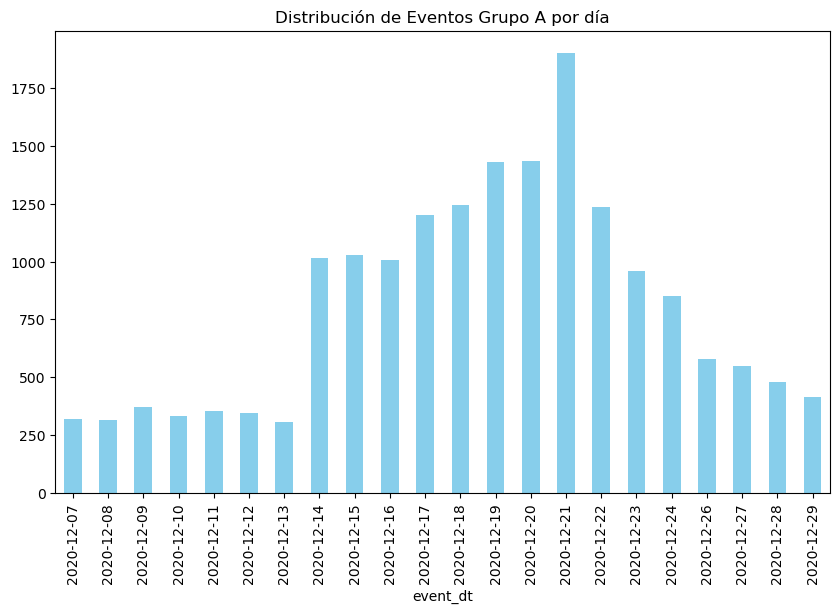

In [40]:
#agrupar
events_dat_groupA = events_a.groupby(events_a['event_dt'].dt.date)['event_name'].count() 
#Histrograma

plt.figure(figsize = (10,6))
events_dat_groupA.plot(kind='bar',color='skyblue')
plt.title('Distribución de Eventos Grupo A por día')
plt.show()

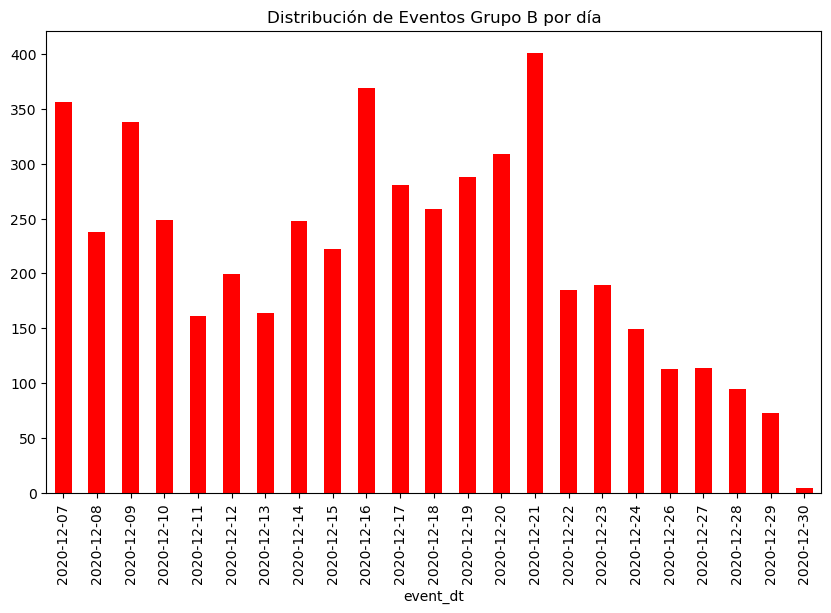

In [41]:
#agrupar
events_dat_groupB = events_b.groupby(events_b['event_dt'].dt.date)['event_name'].count() 
#Histrograma

plt.figure(figsize = (10,6))
events_dat_groupB.plot(kind='bar',color='red')
plt.title('Distribución de Eventos Grupo B por día')
plt.show()

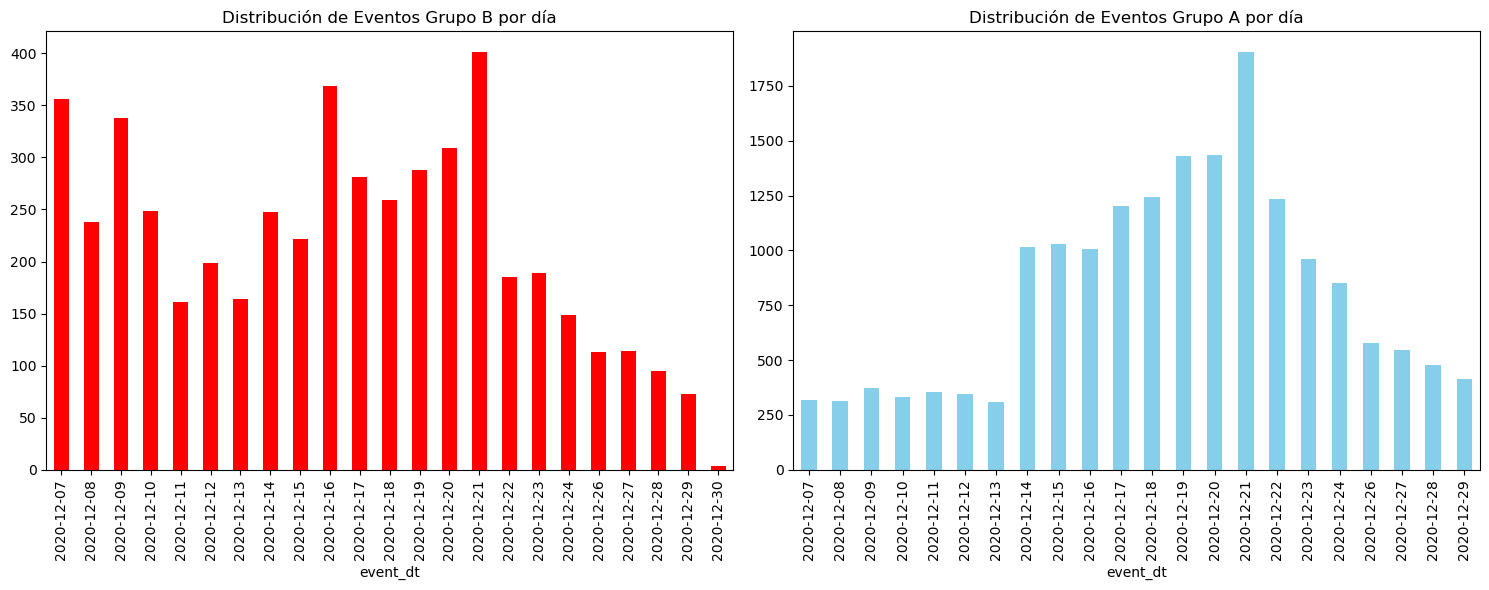

In [42]:
# Agrupar datos
events_dat_groupB = events_b.groupby(events_b['event_dt'].dt.date)['event_name'].count()
events_dat_groupA = events_a.groupby(events_a['event_dt'].dt.date)['event_name'].count()

# Crear los subplots en una fila
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma para el Grupo B
events_dat_groupB.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Distribución de Eventos Grupo B por día')

# Histograma para el Grupo A
events_dat_groupA.plot(kind='bar', color='skyblue', ax=axes[1])
axes[1].set_title('Distribución de Eventos Grupo A por día')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [43]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define los colores para cada paso del embudo
colores = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

# Crear la figura con subplots en una sola fila
fig = make_subplots(rows=1, cols=2, subplot_titles=("Embudo de Conversión Grupo A", "Embudo de Conversión Grupo B"))

# Embudo Grupo A
fig.add_trace(
    go.Funnel(
        y=embudo_a['event_name'],
        x=embudo_a['user_id'],
        textinfo="label+value+percent previous",
        text=embudo_a['tasa_conv'],
        marker=dict(color=colores)
    ),
    row=1, col=1
)

# Embudo Grupo B
fig.add_trace(
    go.Funnel(
        y=embudo_b['event_name'],
        x=embudo_b['user_id'],
        textinfo="label+value+percent previous",
        text=embudo_b['tasa_conv'],
        marker=dict(color=colores)
    ),
    row=1, col=2
)

# Ajustes de layout para el título y el espaciado
fig.update_layout(title="Embudo de Conversión Comparativo: Grupo A vs Grupo B", showlegend=False)
fig.show()


Grupo A - Tasa de conversión = 31%
Grupo B - Tasa de conversión = 26%

Significa que 

### Prueba Z

In [46]:
conversionA = 2430
conversionB = 649
totalA = 7846
totalB = 2415
#proporciones
pA = conversionA / totalA
pB = conversionB / totalB
print(pA,pB)
#propoción combinada

p_combinada = (conversionA + conversionB ) / (totalB + totalA)

#error estándar

error_std = np.sqrt(p_combinada*(1-p_combinada))*((1 / totalA) + (1 / totalB))

#Estadistico Z

z_estadistico = ( pA - pB ) / error_std

#valor P

p_valor = 2* (1-norm.cdf(abs(z_estadistico)))

print(f"Estaditico Z:",z_estadistico)

print(f"Valor P: ", p_valor)

0.3097119551363752 0.26873706004140785
Estaditico Z: 165.10329641932003
Valor P:  0.0


Conclusión:

Existe una diferencia significativa entre los 2 grupos.
El grupo B tiene un impacto menor que el grupo A, por lo que el ajuste para mejorar la tasa de conversión no es adecuado.
No se logra el objetivo de tener un 10% de aumento en la tasa de conversión entre el grupo A y grupo B.
1.- Es necesario tener grupos del mismo número de participantes.
2.- Es necesario buscar mejoras para lograr una mejor tasa de conversión.

In [45]:
#Segunda forma de hacer prueba Z.

converionAB = [conversionA , conversionB]
n = [totalA, totalB]

# Prueba Z

z_stat, p_value = sm.stats.proportions_ztest(converionAB,n)

print("Valor Z",z_stat)
print("valor P",p_value)

Valor Z 3.8420929624701574
valor P 0.00012198961229871237
